In [80]:
import keras
import tensorflow as tf
print("Keras Current Version:", keras.__version__, "Tensorflow Current Version:", tf.__version__)

Keras Current Version: 3.3.3 Tensorflow Current Version: 2.16.1


In [81]:
from glob import glob
import random, os, datetime

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, metrics
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models  import Sequential, load_model
from tensorflow.keras.metrics import Accuracy, AUC

from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [82]:
def get_image_paths(root_dir, num_images=None):
    all_images = []
    for extension in ['*.jpg', '*.jpeg', '*.png']:
        all_images.extend(glob(os.path.join(root_dir, '**', extension), recursive=True))
    if num_images is None:
        return all_images
    else:
        return random.sample(all_images, min(num_images, len(all_images)))


def display_images(img_list):
    plt.figure(figsize=(15, 6))
    for i, img_path in enumerate(img_list):
        img = image.load_img(img_path)
        img = image.img_to_array(img, dtype=np.uint8)
        plt.subplot(2, 5, i + 1)
        plt.imshow(img.squeeze())
        plt.axis('off')
        plt.title(f'Image {i+1}')
    plt.tight_layout()
    plt.show()


In [83]:
path = "/kaggle/input/remotesensing/Remote sensing satellite images dataset for objects detection/rssid"

In [84]:
dir_path = "/kaggle/input/remotesensing/Remote sensing satellite images dataset for objects detection/rssid"

In [85]:
img_list = get_image_paths(dir_path)

print(len(img_list))

92


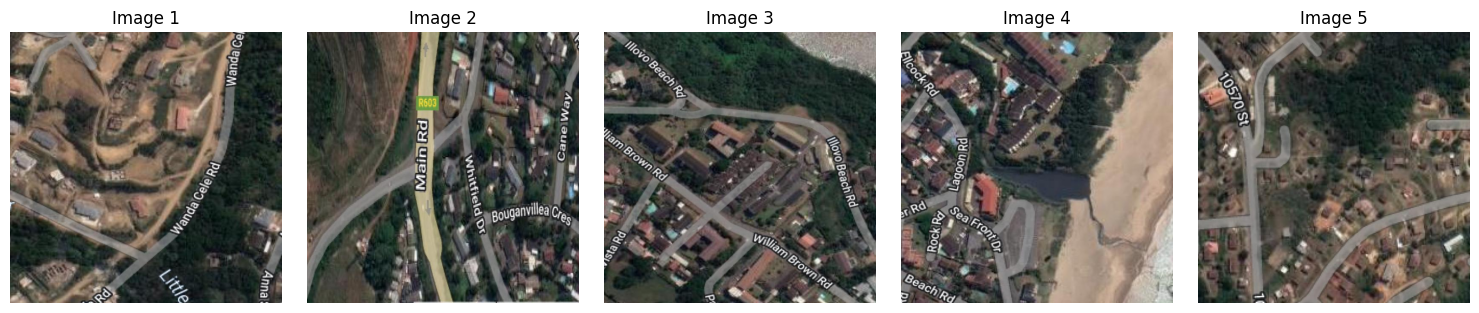

In [86]:
display_images(img_list[0:5])


In [87]:
train = ImageDataGenerator(horizontal_flip=True,
                         vertical_flip=True,
                         validation_split=0.1,
                         rescale=1./255,
                         shear_range = 0.1,
                         zoom_range = 0.1,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,)

val = ImageDataGenerator(rescale=1/255,
                        validation_split=0.1)

In [88]:
train_generator=train.flow_from_directory(dir_path,
                                          target_size=(224, 224),
                                          batch_size=32,
                                          class_mode='categorical',
                                          subset='training')

validation_generator=val.flow_from_directory(dir_path,
                                        target_size=(224, 224),
                                        batch_size=563,
                                        class_mode='categorical',
                                        subset='validation')

Found 83 images belonging to 3 classes.
Found 9 images belonging to 3 classes.


In [89]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import Sequence  # Or other relevant base class if not using Sequence

class PyDataset(Sequence):  # Or any other base class used
    def __init__(self, *args, **kwargs):
        super().__init__(**kwargs)  # Ensure this line is included
        # Your other initializations
        # ...


# Modeli tanımla
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),  # Ekstra Convolutional Katman
    layers.GlobalAveragePooling2D(),  # Flatten yerine Global Average Pooling
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),  # Dropout oranını artırdık
    layers.Dense(3, activation='softmax'),
])

# Optimize edici, kayıp fonksiyonu ve metrikler
metrics = [
    "accuracy",
    AUC(name='auc', multi_label=True)
]

# Daha düşük bir öğrenme oranı ile optimize edici
optimizer = optimizers.Adam(learning_rate=0.0001)  # Öğrenme oranını düşürdük

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=metrics)

# Erken durdurma ve model kontrol noktası
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=15,  # Sabırlılık süresini artırdık
                               verbose=1,
                               restore_best_weights=True)

model_checkpoint = ModelCheckpoint(filepath='satellite.keras',
                                   monitor='val_loss',
                                   save_best_only=True,
                                   save_weights_only=False,
                                   verbose=1)

In [90]:
start_time = datetime.datetime.now()

history = model.fit(train_generator,
                    epochs=10,
                    validation_data=validation_generator,
                    callbacks=[early_stopping, model_checkpoint])

end_time = datetime.datetime.now()
total_duration = end_time - start_time
print("Trainin Time:", total_duration)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4775 - auc: 0.5573 - loss: 1.0884
Epoch 1: val_loss improved from inf to 1.07174, saving model to satellite.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.4967 - auc: 0.5655 - loss: 1.0868 - val_accuracy: 0.6667 - val_auc: 0.4861 - val_loss: 1.0717
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6330 - auc: 0.4914 - loss: 1.0661
Epoch 2: val_loss improved from 1.07174 to 1.04787, saving model to satellite.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.6344 - auc: 0.4978 - loss: 1.0652 - val_accuracy: 0.6667 - val_auc: 0.4196 - val_loss: 1.0479
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6827 - auc: 0.5401 - loss: 1.0417
Epoch 3: val_loss improved from 1.04787 to 1.02246, saving model to satellite.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.6777 - auc: 0.5453 - loss: 1.0406 - val_accuracy: 0.6667 - val_auc: 0.4620 - val_loss: 1.0225
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━

In [91]:
val_loss, val_accuracy, val_auc = model.evaluate(validation_generator, verbose=0)
print(f"Loss: {val_loss}")
print(f"Accuracy: {val_accuracy}")
print(f"AUC: {val_auc}")

Loss: 0.8744167685508728
Accuracy: 0.6666666865348816
AUC: 0.3935185372829437


In [92]:
def plot_training_history(history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy'):

    #Loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_loss], label='Training Loss')
    plt.plot(history.history[val_loss], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Metrics
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_metric], label=f"Training: {train_metric}")
    plt.plot(history.history[val_metric], label=f"Validation: {val_metric}")
    plt.title(f'Training and Validation {train_metric} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(f'train_metric')
    plt.legend()
    plt.show()

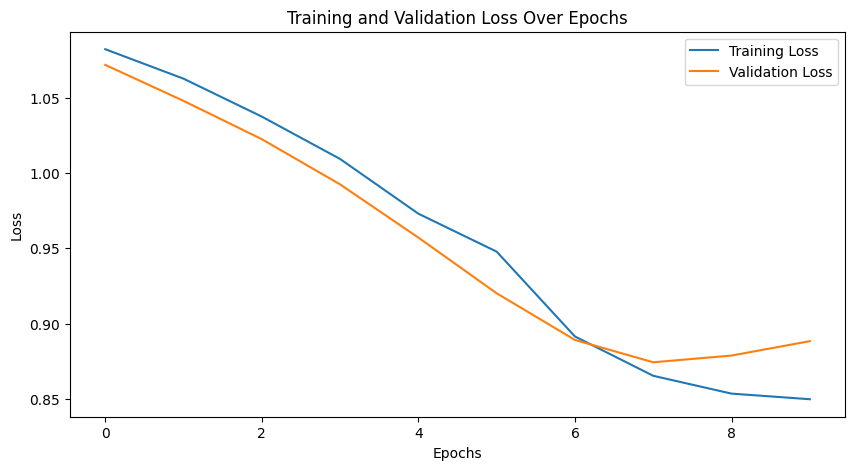

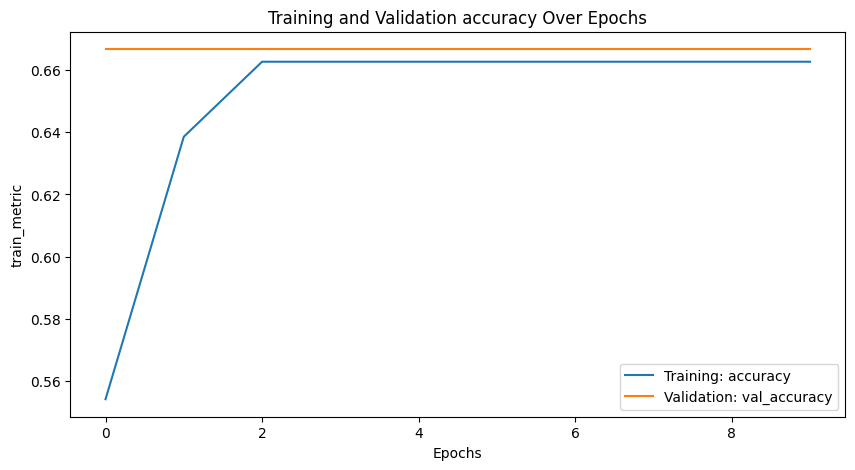

In [93]:
plot_training_history(history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy')